In [83]:
import networkx as nx
import numpy as np
from numpy.random import choice
from collections import OrderedDict
import json
%matplotlib inline

seed = 17
np.random.seed(17)

np.set_printoptions(precision=2)

In [105]:
# Use an geometric distribution to determine how many targets in each cluster to attach to
# Use a preferential attachment distribution over the cluster to determine which get attachments
# Have wide bridge connectors connect to eachother with bernoulli dist

def generate_graph(cluster_sizes=[50,50, 50], attachment_number_mean = 5, inter_bridge_connection_prob =  0.05, wide_bridge_size = 14):
    # Make k clusters
    clusters = []
    indexSum = 0
    sg = nx.Graph()
    for i, cluster_size in enumerate(cluster_sizes):
        tmp = nx.powerlaw_cluster_graph(cluster_size, 3, 0.05, seed=(seed+i))
        tmp = nx.relabel_nodes(tmp, {x:y for x,y in zip(range(0,cluster_size),range(indexSum,indexSum+cluster_size))})
        indexSum += cluster_size
        clusters += [tmp]
        sg = nx.compose(sg, tmp)

    # Make wide bridge nodes
    sgWB = nx.Graph()
    sgWB.add_nodes_from(range(indexSum,indexSum + wide_bridge_size))
    sg = nx.compose(sg, sgWB)
    
    # Determine the number of nodes in each cluster to be attached to
    attachment_numbers = []
    for i, cluster_size in enumerate(cluster_sizes):
        attachment_numbers += [np.random.binomial(cluster_size,attachment_number_mean/cluster_size, size=wide_bridge_size)]

    # Determine preferential attachments
    pa = []
    for cluster_g in (clusters):
        s = np.sum([x[1] for x in cluster_g.degree])
        pa += [[x[1]/s for x in cluster_g.degree]]

    def to_boolean_array(size, indices):
        res = np.zeros(size)
        res[indices] = 1
        return res
    
    attachments = []
    for i in range(len(clusters)):
        attachments += [np.array([to_boolean_array(cluster_sizes[i] ,choice(cluster_sizes[i], x, p=pa[i])) for x in attachment_numbers[i]])]
        
    inter_bridge_attachments = np.random.binomial(1, inter_bridge_connection_prob, size=(wide_bridge_size,wide_bridge_size))
    
    new_edges = []
    
    indexSum_t = 0
    for i in range(len(clusters)):
        new_edges += [(indexSum_t + x,indexSum+wb) for x in range(cluster_sizes[i]) for wb in range(wide_bridge_size) if attachments[i].T[x,wb]] 
        indexSum_t += cluster_sizes[i]
        
    new_edges += [(indexSum+x,indexSum+y) for x in range(wide_bridge_size) for y in range(wide_bridge_size) if inter_bridge_attachments.T[x,y]]

    sg_res = sg.copy()
    sg_res.add_edges_from(new_edges)
    return sg_res

In [106]:
sg = generate_graph()

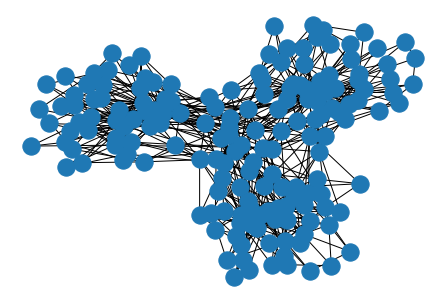

In [107]:
nx.draw(sg)

In [104]:
i = 'a'
graph = sg
with open('graph_'+str(i)+'.txt','wb') as f:
        for line in nx.to_numpy_matrix(graph):
            np.savetxt(f, line, fmt='%.2f')

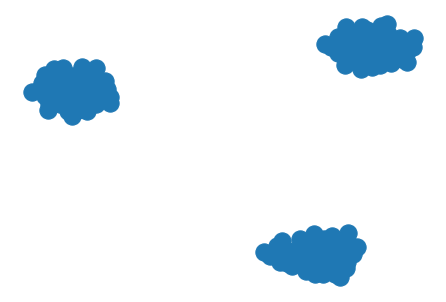